In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

label_encoder_path = "label_encoder.pkl"

if not os.path.exists(label_encoder_path):
    label_encoder = fit_label_encoder(parquet_folder_all, label_encoder_path)
else:
    with open(label_encoder_path, "rb") as f:
      label_encoder = pickle.load(f)

# Đường dẫn
data_dir = '/content/drive/MyDrive/TimeSeries/Data'
batch_data_dir = '/content/drive/MyDrive/TimeSeries/Demo_Data_an'
model_path = '/content/drive/MyDrive/TimeSeries/model_stock.keras'
batch_index_path = '/content/drive/MyDrive/TimeSeries/current_batch.txt'

# Lấy danh sách file
all_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.parquet')])

# Đọc batch hiện tại
try:
    if os.path.exists(batch_index_path):
        with open(batch_index_path, 'r') as f:
            current_batch = int(f.read().strip())
    else:
        current_batch = 0
except Exception as e:
    print(f"Lỗi khi đọc batch index: {e}")
    current_batch = 0

batch_size = 5
start = current_batch * batch_size
end = start + batch_size
batch_files = all_files[start:end]

if not batch_files:
    print("Tất cả batch đã được huấn luyện.")
else:
    # Xóa và tạo lại thư mục batch
    try:
        if os.path.exists(batch_data_dir):
            for f in os.listdir(batch_data_dir):
                os.remove(os.path.join(batch_data_dir, f))
        else:
            os.makedirs(batch_data_dir)

        # Copy file
        for file in batch_files:
            src = os.path.join(data_dir, file)
            dst = os.path.join(batch_data_dir, file)
            os.system(f'cp "{src}" "{dst}"')
    except Exception as e:
        print(f"Lỗi khi chuẩn bị batch: {e}")
        exit()

    print(f"Batch {current_batch + 1} gồm các file:")
    for f in batch_files:
        print(f"   - {f}")

    # Hàm đọc và tiền xử lý dữ liệu
    def load_batch_data(folder):
        X_all, y_all = [], []
        scaler = MinMaxScaler()
        for file in os.listdir(folder):
            try:
                df = pd.read_parquet(os.path.join(folder, file))
                df = df.dropna()
                if len(df) < 60:  # Bỏ qua file không đủ dữ liệu
                    continue
                close = df['close'].values.reshape(-1, 1)
                close = scaler.fit_transform(close)
                window = 60
                for i in range(window, len(close)):
                    X_all.append(close[i-window:i])
                    y_all.append(close[i])
            except Exception as e:
                print(f"Lỗi khi xử lý file {file}: {e}")
        return np.array(X_all), np.array(y_all)

    X, y = load_batch_data(batch_data_dir)
    if len(X) == 0:
        print("Không có dữ liệu hợp lệ. Bỏ qua batch này.")
    else:
        # Chia train/val với shuffle=False để tránh rò rỉ thời gian
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.1, shuffle=False
        )

        # Tạo hoặc tải model
        try:
            if os.path.exists(model_path):
                print("📥 Đang tải mô hình hiện có...")
                model = load_model(model_path)
            else:
                print("🛠️ Đang tạo mô hình mới...")
                # model = Sequential([
                #   input_shape=(X_train.shape[1], X_train.shape[2]),
                #   Conv1D(64, kernel_size=3, activation='relu'),
                #   MaxPooling1D(pool_size=2),
                #   Conv1D(32, kernel_size=3, activation='relu'),
                #   MaxPooling1D(pool_size=2),
                #   Flatten(),
                #   Dropout(0.2),
                #   Dense(64, activation='relu'),
                #   Dense(1)
                # ])
                # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
                model = Sequential([
                    Conv1D(64, kernel_size=3, activation='relu',
                          input_shape=(X_train.shape[1], X_train.shape[2])),
                    MaxPooling1D(pool_size=2),
                    Flatten(),
                    Dense(50, activation='relu'),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mse')
        except Exception as e:
            print(f"Lỗi khi khởi tạo model: {e}")
            exit()

        # Callbacks
        callbacks = [
            EarlyStopping(patience=3, monitor='val_loss'),
            ModelCheckpoint(
                model_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        # Huấn luyện
        try:
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=10,
                batch_size=32,
                callbacks=callbacks,
                verbose=1
            )
            print(f"Đã lưu mô hình tốt nhất vào {model_path}")
        except Exception as e:
            print(f"Lỗi khi huấn luyện: {e}")

        # Cập nhật batch
        try:
            current_batch += 1
            with open(batch_index_path, 'w') as f:
                f.write(str(current_batch))
            print(f"Đã cập nhật tiến trình: Batch {current_batch}")
        except Exception as e:
            print(f"Lỗi khi lưu tiến trình: {e}")

Batch 42 gồm các file:
   - BURL-MINUTES1.parquet
   - BWA-MINUTES1.parquet
   - BWXT-MINUTES1.parquet
   - BXP-MINUTES1.parquet
   - BYND-MINUTES1.parquet
📥 Đang tải mô hình hiện có...
Epoch 1/10
74274/74281 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3697e-06
Epoch 1: val_loss improved from inf to 0.00002, saving model to /content/drive/MyDrive/TimeSeries/model_stock.keras
74281/74281 ━━━━━━━━━━━━━━━━━━━━ 307s 4ms/step - loss: 2.3697e-06 - val_loss: 2.0640e-05
Epoch 2/10
74267/74281 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1713e-06
Epoch 2: val_loss improved from 0.00002 to 0.00001, saving model to /content/drive/MyDrive/TimeSeries/model_stock.keras
74281/74281 ━━━━━━━━━━━━━━━━━━━━ 314s 4ms/step - loss: 2.1713e-06 - val_loss: 6.0739e-06
Epoch 3/10
74273/74281 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2089e-06
Epoch 3: val_loss did not improve from 0.00001
74281/74281 ━━━━━━━━━━━━━━━━━━━━ 329s 4ms/step - loss: 2.2089e-06 - val_loss: 6.2120e-06
Epoch 4/10
74270/74281 ━━━━━━━━━━━━━━━━

32681/32681 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step


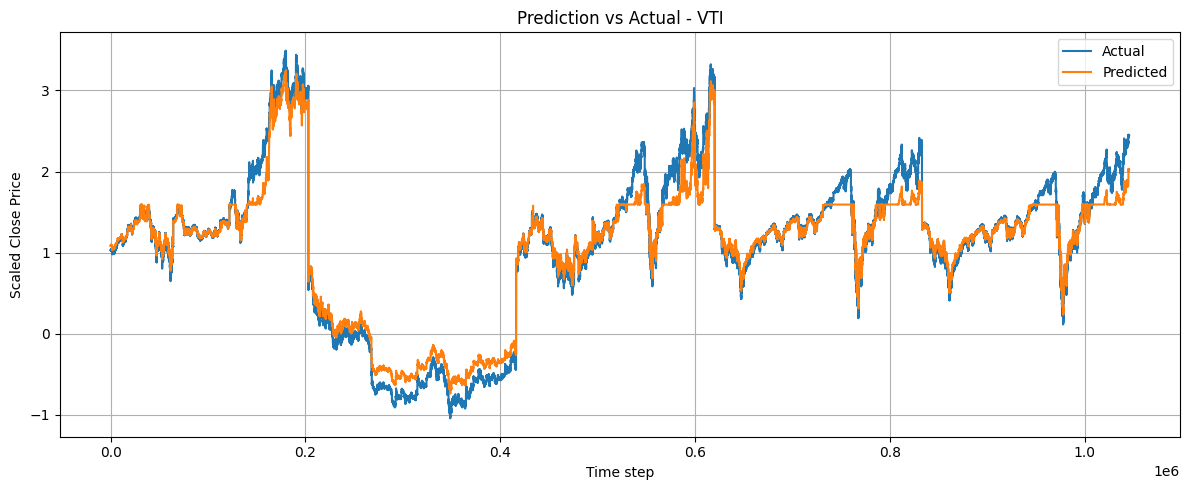

In [ ]:
import matplotlib.pyplot as plt

# Dự đoán trên toàn bộ tập test
y_pred = model.predict(X_test).flatten()

# Tạo DataFrame để dễ xử lý
results_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
    "ticker_id": ticker_ids[-len(y_test):]  # ticker_ids tương ứng đoạn test
})

# Lấy thông tin mapping từ ticker_id → ticker name
id_to_ticker = {i: t for i, t in enumerate(label_encoder.classes_)}

# Vẽ biểu đồ cho từng mã
for tid in results_df["ticker_id"].unique():
    df_ticker = results_df[results_df["ticker_id"] == tid]
    ticker_name = id_to_ticker[tid]

    plt.figure(figsize=(12, 5))
    plt.plot(df_ticker["y_true"].values, label="Actual")
    plt.plot(df_ticker["y_pred"].values, label="Predicted")
    plt.title(f"Prediction vs Actual - {ticker_name}")
    plt.xlabel("Time step")
    plt.ylabel("Scaled Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


19549/19549 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


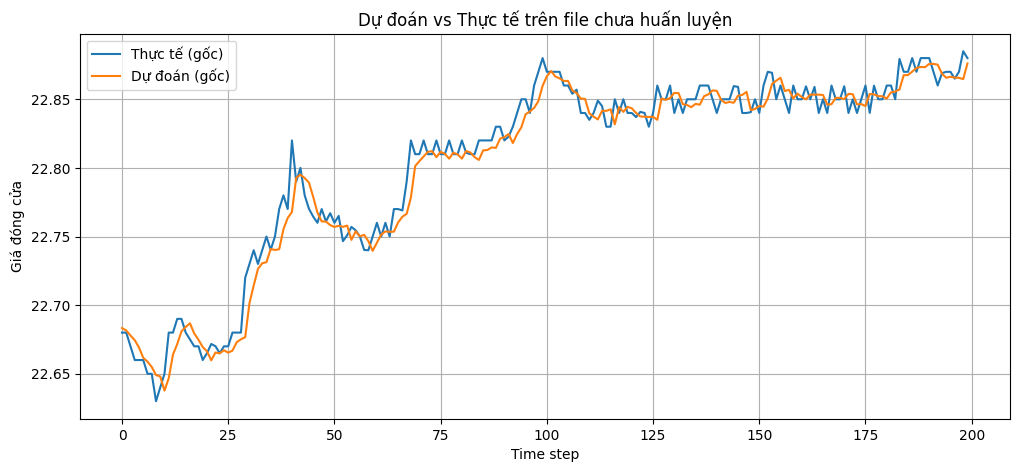

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# --- Đường dẫn ---
model_path = '/content/drive/MyDrive/TimeSeries/model_stock.keras'
file_path = '/content/drive/MyDrive/TimeSeries/Data/WTR-MINUTES1.parquet'  # file chưa huấn luyện

# --- Tải mô hình ---
model = load_model(model_path)

# --- Đọc và chuẩn bị dữ liệu ---
df = pd.read_parquet(file_path)
df = df.dropna()
if len(df) < 60:
    raise ValueError("File không đủ dữ liệu")

# --- Chuẩn hóa giá đóng cửa ---
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# --- Tạo X (window) và y ---
window = 60
X = []
y = []

for i in range(window, len(close_scaled)):
    X.append(close_scaled[i-window:i])
    y.append(close_scaled[i])

X = np.array(X)
y = np.array(y)

# --- Dự đoán ---
y_pred = model.predict(X)

# --- Đảo chuẩn hóa ---
y_true_inv = scaler.inverse_transform(y)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Trực quan hóa ---
plt.figure(figsize=(12, 5))
plt.plot(y_true_inv[:200], label='Thực tế (gốc)')
plt.plot(y_pred_inv[:200], label='Dự đoán (gốc)')
plt.title('Dự đoán vs Thực tế trên file chưa huấn luyện')
plt.xlabel('Time step')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()


1955/1955 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


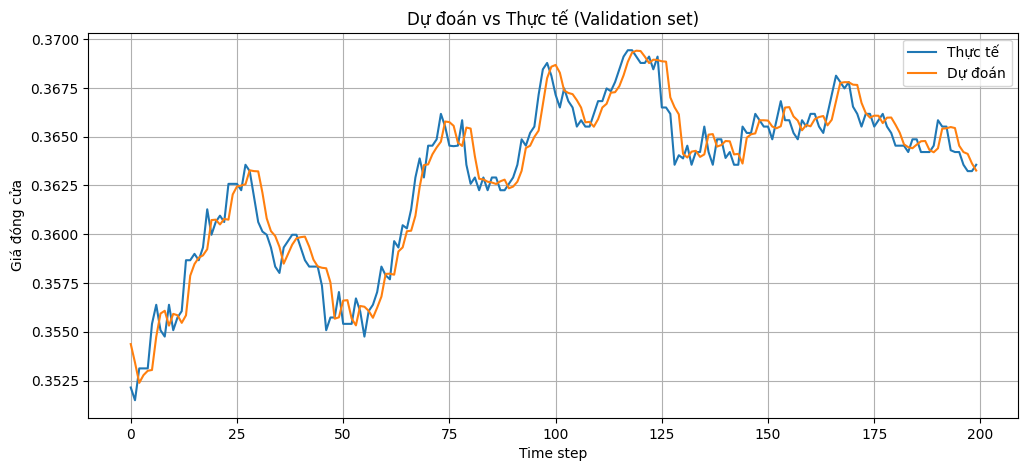

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)
y_pred = model.predict(X_val)

plt.figure(figsize=(12,5))
plt.plot(y_val[:200], label='Thực tế')
plt.plot(y_pred[:200], label='Dự đoán')
plt.title('Dự đoán vs Thực tế (Validation set)')
plt.xlabel('Time step')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()

19549/19549 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


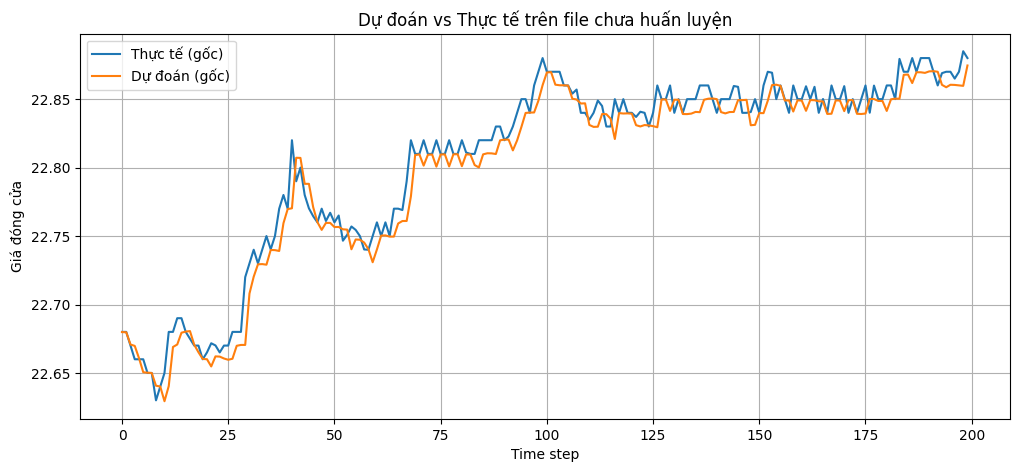

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# --- Đường dẫn ---
model_path = '/content/drive/MyDrive/TimeSeries/model_stock.keras'
file_path = '/content/drive/MyDrive/TimeSeries/Data/WTR-MINUTES1.parquet'  # file chưa huấn luyện

# --- Tải mô hình ---
model = load_model(model_path)

# --- Đọc và chuẩn bị dữ liệu ---
df = pd.read_parquet(file_path)
df = df.dropna()
if len(df) < 60:
    raise ValueError("File không đủ dữ liệu")

# --- Chuẩn hóa giá đóng cửa ---
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# --- Tạo X (window) và y ---
window = 60
X = []
y = []

for i in range(window, len(close_scaled)):
    X.append(close_scaled[i-window:i])
    y.append(close_scaled[i])

X = np.array(X)
y = np.array(y)

# --- Dự đoán ---
y_pred = model.predict(X)

# --- Đảo chuẩn hóa ---
y_true_inv = scaler.inverse_transform(y)
y_pred_inv = scaler.inverse_transform(y_pred)

# --- Trực quan hóa ---
plt.figure(figsize=(12, 5))
plt.plot(y_true_inv[:200], label='Thực tế (gốc)')
plt.plot(y_pred_inv[:200], label='Dự đoán (gốc)')
plt.title('Dự đoán vs Thực tế trên file chưa huấn luyện')
plt.xlabel('Time step')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()